![DSL_logo](dsl_logo.png)


# Advanced Text Analysis with Python

Welcome to the Digital Scholarship Lab introduction to Text Analysis with Python class. In this class we'll learn some more advanced text analysis techniques. We will perform a topic modeling exercise using [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). This workshop assumes you've completed our Introduction to Text Analysis [workshop](https://brockdsl.github.io/Text_Analysis_with_Python/) It would be useful to consult our Introduction to Python [Workshop](https://brockdsl.github.io/Intro_to_Python_Workshop/) for a basic introduction to the language. 


We'll use the Zoom's chat feature to interact.

Be sure to enable line numbers by looking for the 'gear' icon and checking the box in the 'Editor' panel.


[https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Before we Begin!

1. Please click the 'Copy to Drive' button in the toolbar above
1. Click on the Gear icon next to your picture, Select 'Editor' and make sure 'Show Line Numbers' is selected
1. Share in the chat box a quick hello and where you are in the world right now.

# Libraries, Libraries, Libraries

We need lots of different bits and pieces to build and run our project. Please run the following cell to do that. It might take a bit for it to finish however!

In [ ]:
# spacy for lemmatization
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pyLDAvis


# Gensim
import gensim
import nltk
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import warnings

import gensim.corpora as corpora
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from pprint import pprint
from random import randint


#Set some parameters
%matplotlib inline
nltk.download('stopwords')
pd.set_option('display.max_colwidth', 999)
pyLDAvis.enable_notebook()
TOPICS_TO_SHOW = 5
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


#LDA MODEL PARAMETERS

print("\nDone importing Librarians!")

# The general steps for Topic Modelling

- Remove Stopwords
- Create Bigrams
- Lemmitize the text
- Create Bags of words
- Feed Bags of words into LDA model builder

# Corpus


![winnie_splash](https://raw.githubusercontent.com/BrockDSL/Text_Analysis_with_Python/master/winnie_splash.png)

if you joined us for our first text analysis workshop this will look familiar.

Corpus is a fancy way of saying the text that we will be looking at. Cleaning up a corpus and getting it ready for analysis is a big part of the process, once that is done the rest is easy. For our example we are going to be looking at some entries from the 1900 [diary](https://dr.library.brocku.ca/handle/10464/7282) of Winnie Beam. The next cell will load this corpus into a Pandas dataframe and show us a few entires. 

In [167]:
winnie_corpus = pd.read_csv('https://raw.githubusercontent.com/BrockDSL/Text_Analysis_with_Python/master/winnie_corpus.txt', header = None, delimiter="\t")
winnie_corpus.columns = ["page","date","entry"]
winnie_corpus['date'] = pd.to_datetime(winnie_corpus['date'])
winnie_corpus['entry'] = winnie_corpus.entry.astype(str)

data = winnie_corpus["entry"].tolist()


#preview our top entries
winnie_corpus.head()

,page,date,entry
0,7,1900-01-01,"New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth."
1,7,1900-01-02,"Went uptown in afternoon. Was up to Eckardt's but Miss Macfarlane was not there so I did not get what I wanted. Called at office and Nettie came home with me for tea. Mr Carman came over and borrowed my Mildred books. Then Leta came & borrowed my German Grammar as she forgot hers & left it at school before holiday. Papa, mamma, Nettie & I played crokinole. Mamma & I beat. The 2nd Contingent left for Toronto today to go to South Africa. Dr King's som went."
2,8,1900-01-03,"Mrs Trusty was here washing School started to-day, but I was not going this week. Mamma went to the church and then to Mrs Chatfields Took her the church books. The queen Street Baptist church had a service of praise this evening. Mrs Chapman is organist & Mrs Read-Muir sang Mrs George Armstrong has a daughter was born on New Year's day."
3,8,1900-01-04,"Went over to Carman's to have Ella go with me to Dunn's greenhouse. We went about half past three. I brought a primrose Miss Chaplin was in there. Mamma went to Mrs Klotz at home Beatrice helped. Papa & I went to Sunday School entertainment at night. Had a very long programme. There was a dialogue called ""Aunt Ketty's shopping which was good, and a shaving scene. Mr perry gave a tableful of prizes away. Beatrice came home with us. They had a drill of girls & they sang ""Soldiers of the Queen"""
4,9,1900-01-05,"Sweep day. I read ""At the Camerons"" in the ""Harper's Young People"" when mamma was sweeping. We had a beggar in afternoon asking for a few cents as he had a long way to go. Rats! Went over to Lee's in afternoon after eggs. Took a ""Young Ladies Journal"" Mrs Pay lent me. Her kitty has a sore tail. Mrs Malcolmson came after eggs when I was there. She got large sum of 2. Had some candy at night."


## Cleaning Text

Winnie uses _to-day_ and _to-morrow_ instead of contemporary spelling? Should we change this in the entire corpus?

# Prepparing the Corpus!

![Block Image of Pipeline]()


With out text loaded up we need to now process it so when we compare different entries it will be as close as possiblies to **apples to apples**. Applying all of these preparations is often called a pipeline. We'll setup our pipeline in the next cell. 

In [245]:
#Parameters
BIGRAM_MIN = 6
BIGRAM_THRESH = 10

ALLOWED_POSTAGS = [
    "ADJ",
    "ADP",
    "ADV",
    "AUX",
    "CONJ"
    "CCONJ",
    "DET",
    "INTJ",
    "NOUN",
    "PART",
    "PRON",
    "PROPN",
    "SCONJ",
    "VERB"
]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=ALLOWED_POSTAGS):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words = list(sent_to_words(data))
stop_words = stopwords.words('english')
bigram_mod = gensim.models.phrases.Phraser(gensim.models.Phrases(data_words, min_count=BIGRAM_MIN, threshold=BIGRAM_THRESH))
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

print("Done Loading Pipeline")

Done Loading Pipeline


### Stop Words

There are words in Englisht that just connect ideas and phrases but do not add any meaning to our statements. These are generally called stop words and we filter them out from our corpus.

In [22]:
#print out what our Stopwords are
for word in stop_words:
    print(word)

i
me
my
myself
we
our
ours
ourselves
you
you're
you've
you'll
you'd
your
yours
yourself
yourselves
he
him
his
himself
she
she's
her
hers
herself
it
it's
its
itself
they
them
their
theirs
themselves
what
which
who
whom
this
that
that'll
these
those
am
is
are
was
were
be
been
being
have
has
had
having
do
does
did
doing
a
an
the
and
but
if
or
because
as
until
while
of
at
by
for
with
about
against
between
into
through
during
before
after
above
below
to
from
up
down
in
out
on
off
over
under
again
further
then
once
here
there
when
where
why
how
all
any
both
each
few
more
most
other
some
such
no
nor
not
only
own
same
so
than
too
very
s
t
can
will
just
don
don't
should
should've
now
d
ll
m
o
re
ve
y
ain
aren
aren't
couldn
couldn't
didn
didn't
doesn
doesn't
hadn
hadn't
hasn
hasn't
haven
haven't
isn
isn't
ma
mightn
mightn't
mustn
mustn't
needn
needn't
shan
shan't
shouldn
shouldn't
wasn
wasn't
weren
weren't
won
won't
wouldn
wouldn't


### Tokenize words from sentences

We now turn sentences into lists of words

In [23]:
test_text = ["Wow, this is a sentence with words and stuff.",
             "Here is another.",
             "Finally a third",]
for token in sent_to_words(test_text):
    print(token)

['wow', 'this', 'is', 'sentence', 'with', 'words', 'and', 'stuff']
['here', 'is', 'another']
['finally', 'third']


### Bigrams for Phrases

Very common phrases should be kept as phrases. If the two appear next to each enough times we should treat them as a phrase.

In [24]:
documents = ["Sunday School is where you go on Sunday", 
             "Sunday School happens only once a week",]

sentence_stream = [doc.split(" ") for doc in documents]
bigram = gensim.models.Phrases(sentence_stream, min_count=1, threshold=2)

sent = ["Sunday","School","is","where","you","go","on","Sundays"]

print(bigram[sent])


['Sunday_School', 'is', 'where', 'you', 'go', 'on', 'Sundays']


### Lemmitize

Our last prepatory step is to change all of the words in our sentences to their **root words** and at this stage we'll just keep words that are: **Nouns**, **Adjectives**, **Verbs**, & **Adverbs** 

In [25]:
print(lemmatization([["mice"]]))
print(lemmatization([["fishes"]]))

[['mouse']]
[['fish']]


# Applying the pipeline to Diary Entries

Now that we have all of our functions defined we can apply the pipeline to the documents in our corpus. Running the next cell will complete this step. 

In [246]:
# remove stop Words
data_words_nostops = remove_stopwords(data_words)

# form bigrams & trigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# lemmatize
data_lemmatized = lemmatization(data_words_bigrams)

print("Done Prepping the Text!")

Done Prepping the Text!


# How a Random Entry looks

We can now pick individual entries in the corpus and see what they look like when they are processed. Run the cell below a few times and if you find something interesting please share what **random_entry** it was in the chat box. 

In [251]:

random_entry = randint(0,len(data))
#random_entry = 353

print("Random Entry Number: ",random_entry)

print("\n")
print("Original Entry:")
print(data[random_entry])

print("\n")
print("Prepared Text:")

print(data_lemmatized[random_entry])



Random Entry Number:  10


Original Entry:
Did not go to school in the afternoon. The "Musician" for January came to-night. I have to play at Muscial to-night. Called for Beatrice & then Beatrice mamma & I went up Wellington St. to meet Ethel McEdward. When we got the programmes there was a mistake in printing & my name was not on but I played just the same. "Au Matin" by Godard. Miss G. Champman came home with us Eva Robertson played a pretty "Gigue" by Godard.


Prepared Text:
['go', 'school', 'afternoon', 'musician', 'january', 'come', 'night', 'play', 'muscial', 'night', 'call', 'beatrice', 'beatrice', 'mamma', 'go', 'wellington', 'st', 'meet', 'ethel', 'mcedward', 'get', 'programme', 'mistake', 'printing', 'name', 'play', 'au', 'matin', 'godard', 'miss', 'champman', 'came_home', 'us', 'eva', 'robertson', 'play', 'pretty', 'gigue', 'godard']


## Dictionary and corpus etc

With the texts prepped we need to create the 'bag of words', and the dictionary look-up for it

In [252]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency, ie. bag of words
corpus = [id2word.doc2bow(text) for text in texts]

# Building the LDA Model

We'll start with creating a model that only generates two different topics. Why two? This is the smallest number of categories we can get away with.

In [249]:
#CONSISTENT MODEL PARAMETERS

ALPHA ='auto'             #default is 'symmetric'
CHUNKSIZE = 100           #default is 2000
COHERENCE_METHOD = 'c_v'
ITERATIONS = 100          #default is 50
NUM_TOPICS = 0            #default is 100
PASSES = 20               #default is 1
PER_WORD_TOPICS = False  #default is false
RANDOM_STATE = 100
UPDATE_EVERY = 1         #default is 1

In [250]:
#Generate Model and get basic dynamics of it
lda_model_initial = gensim.models.ldamodel.LdaModel(\
                                            alpha=ALPHA,
                                            chunksize=CHUNKSIZE,
                                            corpus=corpus,
                                            id2word=id2word,
                                            iterations = ITERATIONS,
                                            num_topics=2,
                                            passes= PASSES,
                                            per_word_topics= PER_WORD_TOPICS,
                                            random_state=RANDOM_STATE,
                                            update_every=UPDATE_EVERY,
                                           )

print("Done Building Inital Model")

cs = CoherenceModel(model = lda_model_initial, \
                               texts = data_lemmatized, \
                               dictionary = id2word, \
                               coherence = COHERENCE_METHOD
                     )
print("Coherence? ",cs.get_coherence())

vis = pyLDAvis.gensim_models.prepare(lda_model_initial,corpus,id2word)
vis

Done Building Inital Model
Coherence?  0.2505261437718759


/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the i

PreparedData(topic_coordinates=             x    y  topics  cluster      Freq
topic                                         
0      0.06846  0.0       1        1  55.48126
1     -0.06846  0.0       2        1  44.51874, topic_info=               Term        Freq       Total Category  logprob  loglift
75           church  132.000000  132.000000  Default  30.0000  30.0000
121   sunday_school   48.000000   48.000000  Default  29.0000  29.0000
17              get  303.000000  303.000000  Default  28.0000  28.0000
18               go  563.000000  563.000000  Default  27.0000  27.0000
702          sermon   31.000000   31.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
60             play   27.973099   65.529447   Topic2  -5.3764  -0.0420
103            give   25.263245   52.977754   Topic2  -5.4783   0.0687
355             see   32.061101  108.886259   Topic2  -5.2400  -0.4134
90             take   30.435929  132.945635   Topic2  -5.2921  -0.6651
1377          drive   22.428678   75.081267   Topic2  -5.5973  -0.3990

[153 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
32        1  0.661240    afternoon
32        2  0.338684    afternoon
405       1  0.957997      another
1609      1  0.942601        apple
1609      2  0.094260        apple
...     ...       ...          ...
68        1  0.927710  went_uptown
68        2  0.061847  went_uptown
1210      1  0.986051         wide
404       1  0.981354        write
1117      2  0.867803          xii

[161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# What are we doing here?

Ultimately we are trying to find the the balance between number of topics in our text and size of our text. If we have the same number of topics as entries, it doesn't tell us much. We will need to find a place where we get comfortable with an amount of topics. We will focus on the range of 4 to 10 topics with this in mind.

##  Initial Coherence Plot

We seek to maximize this! We would like to get over 0.3.

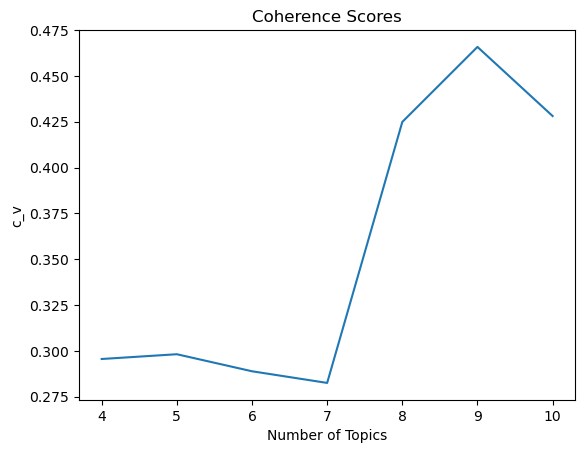

,num_topics,c_v
0,4,0.295566
1,5,0.298164
2,6,0.288869
3,7,0.282509
4,8,0.424910
5,9,0.465835
6,10,0.428131


In [253]:
TOPIC_CHOICES = [4,5,6,7,8,9,10]

c_Scores = []
for t_number in TOPIC_CHOICES:
    lda_model_coh = gensim.models.ldamodel.LdaModel(\
                                                alpha=ALPHA,
                                                chunksize=CHUNKSIZE,
                                                corpus=corpus,
                                                id2word=id2word,
                                                iterations = ITERATIONS,
                                                num_topics=t_number,
                                                passes= PASSES,
                                                per_word_topics= PER_WORD_TOPICS,
                                                random_state=RANDOM_STATE,
                                                update_every=UPDATE_EVERY,
                                               )
    
    cs = CoherenceModel(
                        model = lda_model_coh, \
                        texts = data_lemmatized, \
                        dictionary = id2word, \
                        coherence = COHERENCE_METHOD,
                        )
    c_Scores.append(cs.get_coherence())
    
    
plt.plot(TOPIC_CHOICES, c_Scores)
plt.title("Coherence Scores")
plt.ylabel(COHERENCE_METHOD)
plt.xlabel("Number of Topics")
plt.show()
    
cScore_df = pd.DataFrame(list(zip(TOPIC_CHOICES,c_Scores)))
cScore_df.columns = ["num_topics",COHERENCE_METHOD]
cScore_df

# Final Model?

Now that we have some guidance on the number of topics to use, let's build and visualize our model again

In [254]:
NUM_TOPICS = 9

In [255]:
#Generate Model and get basic dynamics of it
lda_model_optimized = gensim.models.ldamodel.LdaModel(\
                                            alpha=ALPHA,
                                            chunksize=CHUNKSIZE,
                                            corpus=corpus,
                                            id2word=id2word,
                                            iterations = ITERATIONS,
                                            num_topics=NUM_TOPICS,
                                            passes= PASSES,
                                            per_word_topics= PER_WORD_TOPICS,
                                            random_state=RANDOM_STATE,
                                            update_every=UPDATE_EVERY,
                                           )

print("Done Building Optimized Model")

cs = CoherenceModel(model = lda_model_optimized, \
                               texts = data_lemmatized, \
                               dictionary = id2word, \
                               coherence = COHERENCE_METHOD
                     )
print("Coherence? ",cs.get_coherence())

vis2 = pyLDAvis.gensim_models.prepare(lda_model_optimized,corpus,id2word)
vis2

Done Building Optimized Model
Coherence?  0.46583465838317806


/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.323959 -0.096960       1        1  57.433728
1      0.216260  0.196797       2        1  17.766423
6      0.017610 -0.185998       3        1   8.013069
4     -0.094109  0.022929       4        1   4.737307
8     -0.088775  0.019861       5        1   3.386432
5     -0.098379  0.004795       6        1   2.512261
0     -0.101528  0.012491       7        1   2.337847
2     -0.098300  0.009750       8        1   2.304870
3     -0.076737  0.016334       9        1   1.508062, topic_info=         Term        Freq       Total Category  logprob  loglift
18         go  631.000000  631.000000  Default  30.0000  30.0000
75     church  142.000000  142.000000  Default  29.0000  29.0000
266       eva   90.000000   90.000000  Default  28.0000  28.0000
17        get  350.000000  350.000000  Default  27.0000  27.0000
1377    drive   79.000000   79.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
77    evening    1.649670   12.247112   Topic9  -4.8220   2.1896
771      york    0.964896    2.306329   Topic9  -5.3583   3.3230
266       eva    2.029453   90.934774   Topic9  -4.6148   0.3920
403    ticket    0.927919    2.859108   Topic9  -5.3974   3.0690
372   tuesday    0.877023    5.661732   Topic9  -5.4538   2.3294

[425 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
373       6  0.567568       abbs
2121      7  0.930321     afraid
32        1  0.960497  afternoon
32        2  0.014022  afternoon
32        3  0.021033  afternoon
...     ...       ...        ...
1211      7  0.968234      world
1117      2  0.983504        xii
1928      7  0.827426        yet
771       1  0.433589       york
771       9  0.433589       york

[501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 7, 5, 9, 6, 1, 3, 4])

# What makes a topic?

Let's look at the top words associated with each topic to see if we can get a sense of what each one might be 'about'

In [256]:
for t in range(0,NUM_TOPICS):
    print("\nTopic Number: ",t+1)
    print("\n")
    topic_phrase = lda_model_optimized.print_topic(t,topn=TOPICS_TO_SHOW)
    for tp in topic_phrase.split("+ "):
        print(tp.replace("*"," -> "))


Topic Number:  1


0.020 -> "deer" 
0.018 -> "wide" 
0.017 -> "order" 
0.017 -> "uncle_horace" 
0.014 -> "world"

Topic Number:  2


0.062 -> "go" 
0.050 -> "church" 
0.023 -> "lesson" 
0.021 -> "sunday_school" 
0.019 -> "mr"

Topic Number:  3


0.024 -> "hat" 
0.018 -> "boyle" 
0.016 -> "paint" 
0.014 -> "kitchen" 
0.013 -> "murphy"

Topic Number:  4


0.023 -> "quite" 
0.012 -> "run" 
0.011 -> "cool" 
0.010 -> "eva" 
0.010 -> "tom"

Topic Number:  5


0.020 -> "rainy" 
0.013 -> "story" 
0.012 -> "aunt_allie" 
0.011 -> "black" 
0.011 -> "hamilton"

Topic Number:  6


0.040 -> "ready" 
0.016 -> "basket" 
0.013 -> "ring" 
0.012 -> "store" 
0.010 -> "valse"

Topic Number:  7


0.025 -> "go" 
0.022 -> "drive" 
0.018 -> "overholt" 
0.012 -> "st" 
0.011 -> "stamp"

Topic Number:  8


0.058 -> "go" 
0.044 -> "get" 
0.040 -> "mamma" 
0.025 -> "papa" 
0.023 -> "come"

Topic Number:  9


0.020 -> "frank" 
0.018 -> "warm" 
0.017 -> "tie" 
0.010 -> "meat" 
0.009 -> "francis"


# Which Entries Go to Which Topics?

Now that we have a stable description of topics in the text. Let's see which entries are associated with each topic

In [267]:
top_cats = []
top_prop = []

for i in range(0,len(corpus)):
  #print(f_lookup[i], "->",sorted(lda_model.get_document_topics(corpus[i]),key = lambda tup: tup[1],reverse=True)[0])
  top_cats.append(sorted(lda_model_optimized.get_document_topics(corpus[i]),key = lambda tup: tup[1],reverse=True)[0][0] + 1)
  top_prop.append(sorted(lda_model_optimized.get_document_topics(corpus[i]),key = lambda tup: tup[1],reverse=True)[0][1])


winnie_corpus['topic'] = top_cats
winnie_corpus['prob_for_topic'] = top_prop

winnie_corpus.groupby(['topic'])[['entry']].count()

,entry
topic,
1,2
2,48
5,4
6,1
7,10
8,294
9,4


## Closer look at a topic?

Change the value of **topic_to_view** to a number in the list above to see the top 15 words identified with that topic and 5 random entries that have that topic as the primary identified topic of the entry

In [268]:
topic_to_view = 2
topic_phrase = lda_model_optimized.print_topic(topic_to_view-1,topn=TOPICS_TO_SHOW)
print("\n=== Topics: ")
for tp in topic_phrase.split("+ "):
    print(tp.replace("*"," -> "))

sample_item = winnie_corpus[(winnie_corpus['topic'] == topic_to_view)].sample(1)

#sample_item.index
print("\n=== Lemmatized entry: ")
print(data_lemmatized[sample_item.index.astype(int)[0]])
sample_item


=== Topics: 
0.062 -> "go" 
0.050 -> "church" 
0.023 -> "lesson" 
0.021 -> "sunday_school" 
0.019 -> "mr"

=== Lemmatized entry: 
['church', 'morning_sermon', 'phil', 'th', 'verses', 'communion', 'sunday', 'afternoon', 'snow', 'hard', 'go', 'sunday_school', 'mamma', 'headache', 'go', 'night', 'read', 'titus', 'chief', 'character', 'titus', 'son', 'high', 'priest', 'caiapha', 'steal', 'servant', 'prisea', 'young', 'husband', 'ruffian', 'titus', 'suppose', 'father', 'thief', 'hang', 'cross', 'christ', 'crucifixion']


,page,date,entry,topic,prob_for_topic
62,38,1900-03-04,"Was at church in the morning Sermon Phil 3. 13 & 14th verses Communion Sunday. In the afternoon it was snowing hard so I did not go to Sunday School. Mamma had a headache so we did not go at night. I read ""Titus"" over again. The chief character is Titus the son of the high priest Caiaphas, but he was stolen by a servant Prisea when he was young and her husband was a ruffian and Titus & the supposed father were the thieves hung on the cross at Christ's crucifixion",2,0.892591


## EG 2

Now that we have looked at the topic modelling of the Winnie Beam diary let's see if we can apply the same lessons to another corpus.